In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [2]:
df1 = pd.read_csv("data/train_preliminary/user.csv")
df2 = pd.read_csv("data/train_preliminary/ad.csv")
df3 = pd.read_csv("data/train_preliminary/click_log.csv")
df_tmp = pd.merge(df3, df1, left_on='user_id', right_on='user_id')
df = pd.merge(df_tmp, df2, left_on='creative_id', right_on='creative_id')
order = ['user_id', 'time', 'creative_id', 'click_times', 'ad_id', 'product_category', 'advertiser_id']
df = df[order]
df.head()

,user_id,time,creative_id,click_times,ad_id,product_category,advertiser_id
0,30920,9,567330,1,504423,3,32638
1,320815,15,567330,1,504423,3,32638
2,355089,11,567330,1,504423,3,32638
3,363442,9,567330,1,504423,3,32638
4,370513,14,567330,1,504423,3,32638


In [3]:
df.sort_values(['user_id', 'time'], inplace=True)

In [4]:
df

,user_id,time,creative_id,click_times,ad_id,product_category,advertiser_id
16204330,1,20,877468,1,773445,5,29455
23067470,1,20,209778,1,188507,2,9702
26781033,1,20,821396,1,724607,5,7293
22502290,1,39,1683713,1,1458878,5,14668
9504689,1,40,122032,1,109959,2,11411
...,...,...,...,...,...,...,...
28703035,900000,57,2692144,1,2316309,5,14372
15724163,900000,71,3391205,1,2918341,5,22137
7226547,900000,72,3471208,1,2989104,5,7283
9638586,900000,74,3527098,1,3037879,18,14681


In [5]:
df.reset_index(drop=True, inplace=True)
df

,user_id,time,creative_id,click_times,ad_id,product_category,advertiser_id
0,1,20,877468,1,773445,5,29455
1,1,20,209778,1,188507,2,9702
2,1,20,821396,1,724607,5,7293
3,1,39,1683713,1,1458878,5,14668
4,1,40,122032,1,109959,2,11411
...,...,...,...,...,...,...,...
30082766,900000,57,2692144,1,2316309,5,14372
30082767,900000,71,3391205,1,2918341,5,22137
30082768,900000,72,3471208,1,2989104,5,7283
30082769,900000,74,3527098,1,3037879,18,14681


In [6]:
a = df.groupby('user_id')['click_times'].sum()
a.min()

10

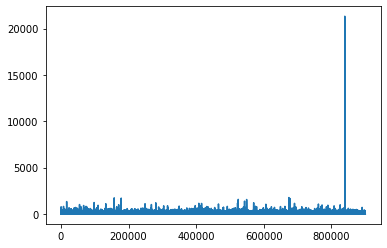

In [7]:
plt.plot(a)

In [8]:
df.groupby('user_id')['user_id'].count().min()

2

In [9]:
df_tmp1 = pd.get_dummies(df['creative_id'] % 10)
print(df_tmp1.shape)
df_tmp2 = pd.get_dummies(df['ad_id'] % 10)
print(df_tmp2.shape)
df_tmp3 = pd.get_dummies(df['product_category'])
print(df_tmp3.shape)
df_tmp4 = pd.get_dummies(df['advertiser_id'] % 10)
print(df_tmp4.shape)

(30082771, 10)
(30082771, 10)
(30082771, 18)
(30082771, 10)


In [28]:
data = np.zeros((100000, 10, 49), dtype = float)
pos = 0
for i in range(100000):
    while df.iloc[pos, 0] != i + 1:
        pos += 1
    now = 0
    while now < 10:
        for k in range(df.iloc[pos, 3]):
            data[i][now][0] = df.iloc[pos][1]
            data[i][now][1:11] = df_tmp1.iloc[pos]
            data[i][now][11:21] = df_tmp2.iloc[pos]
            data[i][now][21:39] = df_tmp3.iloc[pos]
            data[i][now][39:49] = df_tmp4.iloc[pos]
            now += 1
            if now >= 10:
                break
        pos += 1
data

array([[[20.,  0.,  0., ...,  0.,  0.,  0.],
        [20.,  0.,  0., ...,  0.,  0.,  0.],
        [20.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [52.,  0.,  1., ...,  1.,  0.,  0.],
        [60.,  0.,  0., ...,  0.,  0.,  0.],
        [64.,  0.,  0., ...,  0.,  1.,  0.]],

       [[10.,  0.,  1., ...,  0.,  0.,  0.],
        [11.,  0.,  0., ...,  0.,  0.,  0.],
        [14.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [38.,  0.,  0., ...,  0.,  0.,  0.],
        [38.,  1.,  0., ...,  0.,  1.,  0.],
        [39.,  0.,  0., ...,  0.,  0.,  0.]],

       [[12.,  0.,  0., ...,  0.,  0.,  0.],
        [13.,  0.,  0., ...,  1.,  0.,  0.],
        [14.,  0.,  0., ...,  0.,  1.,  0.],
        ...,
        [22.,  0.,  0., ...,  0.,  0.,  0.],
        [31.,  0.,  1., ...,  0.,  0.,  0.],
        [36.,  0.,  0., ...,  0.,  0.,  1.]],

       ...,

       [[23.,  0.,  1., ...,  0.,  0.,  0.],
        [32.,  0.,  0., ...,  0.,  0.,  0.],
        [44.,  0.,  0., ...,  0.,  0.,  0.

In [43]:
Y2_train, Y2_test = df1.iloc[:90000, 2:3], df1.iloc[90000:100000, 2:3]
X_train, X_test = data[:90000,:,:], data[90000:,:,:]
model = Sequential()
model.add(LSTM(32, input_shape=(data.shape[1], data.shape[2])))
model.add(Dense(1))
model.compile(loss='MSE', optimizer='adam')
model.fit(X_train, Y2_train, nb_epoch=100)

/Users/lixiang/Documents/GitHub/xzwbsrz_pre/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/100
90000/90000 [==============================] - 12s 129us/step - loss: 0.2172
Epoch 2/100
90000/90000 [==============================] - 11s 126us/step - loss: 0.2075
Epoch 3/100
90000/90000 [==============================] - 11s 128us/step - loss: 0.2019
Epoch 4/100
90000/90000 [==============================] - 12s 130us/step - loss: 0.1983
Epoch 5/100
90000/90000 [==============================] - 11s 125us/step - loss: 0.1955
Epoch 6/100
90000/90000 [==============================] - 11s 128us/step - loss: 0.1930
Epoch 7/100
90000/90000 [==============================] - 12s 132us/step - loss: 0.1904
Epoch 8/100
90000/90000 [==============================] - 12s 132us/step - loss: 0.1881
Epoch 9/100
90000/90000 [==============================] - 12s 129us/step - loss: 0.1861
Epoch 10/100
90000/90000 [==============================] - 11s 127us/step - loss: 0.1843
Epoch 11/100
90000/90000 [==============================] - 12s 128us/step - loss: 0.1826
Epoch 12/100
90000/

90000/90000 [==============================] - 12s 129us/step - loss: 0.1417
Epoch 93/100
90000/90000 [==============================] - 11s 127us/step - loss: 0.1415
Epoch 94/100
90000/90000 [==============================] - 11s 126us/step - loss: 0.1414
Epoch 95/100
90000/90000 [==============================] - 11s 126us/step - loss: 0.1412
Epoch 96/100
90000/90000 [==============================] - 11s 128us/step - loss: 0.1410
Epoch 97/100
90000/90000 [==============================] - 11s 127us/step - loss: 0.1409
Epoch 98/100
90000/90000 [==============================] - 11s 127us/step - loss: 0.1409
Epoch 99/100
90000/90000 [==============================] - 12s 128us/step - loss: 0.1406
Epoch 100/100
90000/90000 [==============================] - 12s 128us/step - loss: 0.1405


In [44]:
Y = model.predict(X_test)

In [45]:
Y = np.round(Y)

In [46]:
Y2_test

,gender
90000,1
90001,1
90002,1
90003,1
90004,1
...,...
99995,1
99996,1
99997,1
99998,1


In [48]:
ans = 0 
for i in range(10000):
    if Y[i] == Y2_test['gender'][i+90000]:
        ans += 1
print('accurency:', ans/10000)

accurency: 0.7064


In [49]:
Y = model.predict(X_train)
Y = np.round(Y)
ans = 0 
for i in range(90000):
    if Y[i] == Y2_train['gender'][i]:
        ans += 1
print('accurency:', ans/90000)

accurency: 0.8095888888888889


In [57]:
df.groupby('user_id')['click_times'].sum()

user_id
1         14
2         46
3         30
4         29
5         34
          ..
899996    14
899997    20
899998    15
899999    22
900000    12
Name: click_times, Length: 900000, dtype: int64

In [69]:
a = df.groupby('user_id')['click_times'].sum()
a = a.value_counts()
a[a > 100].count()

183

In [65]:
df.groupby('user_id')['click_times'].sum().min()

10

In [84]:
a = df.groupby('user_id')['click_times'].count()
a[a > 500].count()

128